In [39]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
import glob
import json
import os
import pandas as pd
import pickle
import scipy
import math 


from scipy.interpolate import interp1d
import scipy.io as sio
from scipy.optimize import curve_fit

rc = {
    "figure.figsize": (12,6),
    "xtick.major.size": 12.0,
    "xtick.minor.size": 8.0,
    "ytick.major.size": 12.0,
    "ytick.minor.size": 8.0,
    "axes.linewidth": 1.75,
    "xtick.color": '0',
    "ytick.color": '0',
    "axes.labelcolor": '0'
}


%matplotlib inline


# Define functions

In [5]:
def gamma_dist(d,alpha,b,Constant = 1):
    r = 0.5*d
    n_r = Constant*(r**alpha)*np.exp(-1*b*r)
    return n_r
    
def load_MAT_FILE(mat_path):
    if os.path.exists(mat_path):
        print("loading the 3D mat from: {}".format(mat_path))
    else:
        print("{} not exists".format(mat_path))    
    
    matrix3D = sio.loadmat(mat_path)
    return matrix3D

def calcHG(mu, g):
    """Calculate the Henyey-Greenstein function for each voxel.
    The HG function is taken from: http://www.astro.umd.edu/~jph/HG_note.pdf
    """

    HG = (1 - g**2) / (1 + g**2 - 2*g*mu)**(3/2) / (4*np.pi)
    
    return HG

# load 3d data for Mie calculations

In [21]:
# mat_path = "BOMEX_128x128x100_500CCN_0000106200_pdfVARS.mat"
mat_path = "../WIZ_Clouds/erc_proposal/BOMEX_128x128x100_50CCN_50m_0000008400_pdfVARS.mat"
matrix3D = load_MAT_FILE(mat_path)

#matrix3D.keys() = dict_keys(['B', 'C', '__version__', '__globals__', 'fails', 'DominPDFcoeff', '__header__', 'CldMtrx', 
#'alpha'])
CldMtrx = matrix3D['CldMtrx']# a binary cloud matrix that points out where there are cloud, 1- cloude, 0 - no cloud voxel
alpha = matrix3D['alpha']
B = matrix3D['B']
C = matrix3D['C']# modeled droplet concentration, units are [cm^-3]
fails = matrix3D['fails']

"""new parameters 30/7/2018, where:
matrix3D.keys() = dict_keys(['__header__', '__version__', '__globals__', 'B', 
           'BinMPhdata', 'C', 'CldMtrx', 'DominPDFcoeff', 'LWC', 'N', 'RE', 'alpha', 'fails', 'p', 'rd', 'rho'])"""

rd = matrix3D['rd'] #rd - the bins vector (micron)
BinMPhdata = matrix3D['BinMPhdata']#a 4D matrix of the droplet size bins (first 3 are spatial dimensions and the 4th is the 33 size bins) [1/um].
N = matrix3D['N']#number concentration of droplets per voxel (integral of BinMphdata over the 33 bins)  (cm^-3)
alfa =  matrix3D['alpha']
B =  matrix3D['B']
C =  matrix3D['C']

print("content information:")
print("CldMtrx shape is: {}".format(CldMtrx.shape))
print("alpha shape is: {}".format(alpha.shape))
print("B shape is: {}".format(B.shape))
print("C shape is: {}".format(C.shape))
print("fails shape is: {}".format(fails.shape))
print("rd shape is: {}".format(rd.shape))
print("BinMPhdata shape is: {}".format(BinMPhdata.shape))
print("N shape is: {}".format(N.shape))
print("total mediume voxels: {}\n".format(CldMtrx.size))
print("========================================================\n")
M = np.ones(alpha.shape)
print("In {} voxels there are no full fitted parameters.".format(fails.flatten().sum()))
print("There are {} voxels with cloud content".format(CldMtrx.flatten().sum()))
print("In {} voxels there is fitted alpha parameter".format(M.sum() - M[np.isnan(alpha)].flatten().sum()))
print("In {} voxels there is fitted B parameter".format(M.sum() - M[np.isnan(B)].flatten().sum()))
print("In {} voxels there is fitted C parameter".format(M.sum() - M[np.isnan(C)].flatten().sum()))

alpha_not_with_nan = np.nan_to_num(alpha)
B_not_with_nan = np.nan_to_num(B)
C_not_with_nan = np.nan_to_num(C)

loading the 3D mat from: ../WIZ_Clouds/erc_proposal/BOMEX_128x128x100_50CCN_50m_0000008400_pdfVARS.mat
content information:
CldMtrx shape is: (128, 128, 100)
alpha shape is: (128, 128, 100)
B shape is: (128, 128, 100)
C shape is: (128, 128, 100)
fails shape is: (128, 128, 100)
rd shape is: (33, 1)
BinMPhdata shape is: (128, 128, 100, 33)
N shape is: (128, 128, 100)
total mediume voxels: 1638400


In 3249 voxels there are no full fitted parameters.
There are 23535 voxels with cloud content
In 20286.0 voxels there is fitted alpha parameter
In 20286.0 voxels there is fitted B parameter
In 20286.0 voxels there is fitted C parameter


# Work on one voxel to test the units and some operations

Eshkols N = 1.2449157238006592, tested (sanity check) N = 1.2449158376172944


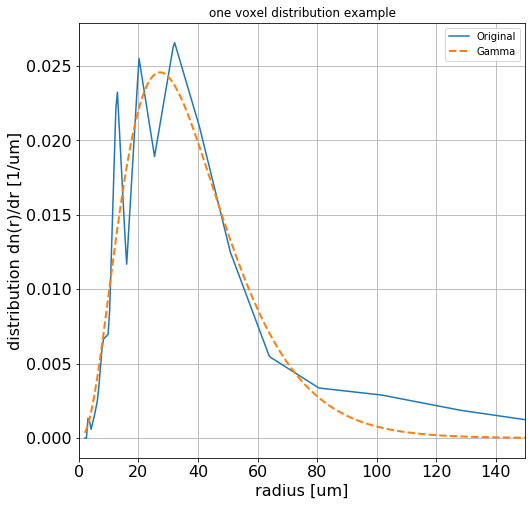

In [34]:
# from plt.plot(rd) - you can see that the bins are not linear
diameters = 2*np.squeeze(rd) # (microns)
min_diff = np.diff(np.squeeze(rd)).min()
interp_bins = int(np.ceil((rd.max() - rd.min())/min_diff))
r = np.linspace(rd.min(), rd.max(), interp_bins)

indxs = np.argwhere(CldMtrx > 0)# cloudy voxel indexes
# here, take for example one voxel with fitted parameters
example_vox_indx = indxs[150]
DOPC = BinMPhdata[example_vox_indx[0],example_vox_indx[1],example_vox_indx[2],:] # distribution of droplets consintration 
NC = N[example_vox_indx[0],example_vox_indx[1],example_vox_indx[2]] # number concentration of droplets
DOPC_interpulated = interp1d(np.squeeze(rd),DOPC)(r)
ALPHA = alfa[example_vox_indx[0],example_vox_indx[1],example_vox_indx[2]]
b = B[example_vox_indx[0],example_vox_indx[1],example_vox_indx[2]]
c = C[example_vox_indx[0],example_vox_indx[1],example_vox_indx[2]]

a = c/(math.gamma(ALPHA+1)/(b**(ALPHA+1)))
test_gamma = gamma_dist(2*r,ALPHA,np.real(b),a)
F = fails[example_vox_indx[0],example_vox_indx[1],example_vox_indx[2]]
"""
parameters for the gamma pdf: the domain average in a vector (alpha,B,C), a matrix of the 3D distribution of each 
gamma parameter separately, a binary cloud matrix that points out where there are cloud (CldMtrx) and a binary matrix 
that has 1 values where I couldn't fit a gamma distribution (fails).
Where alpha=alpha, B=b and C=a*GAMMA(alpha+1)/b^(alpha+1) which is the droplets number concentration.
"""
f, ax = plt.subplots(1, 1, figsize=(8, 8))
plt.plot(r,DOPC_interpulated,label='Original')
plt.xlim([0 ,150])
plt.xlabel('radius [um]', fontsize=16)
plt.ylabel('distribution dn(r)/dr [1/um]', fontsize=16)
plt.title('one voxel distribution example')

# gamma distribution test:
plt.plot(r,test_gamma,linewidth=2.0,label='Gamma',linestyle = '--')

# sanity check on the consintration
# NC_test = np.trapz(DOPC_interpulated,r, axis=0)
NC_test = np.trapz(DOPC,np.squeeze(rd), axis=0)
print("Eshkols N = {}, tested (sanity check) N = {}".format(NC,NC_test))

ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
plt.grid(True)
plt.legend()

# Use pyshdom:

In [1]:
"""
Create a monodisperse Mie scattering table for a set wavelength as a function of radius.
This table can be integrated for Polydisperse Mie scattering as a function of the size-distribution parameters.

Note: 
Running this cell for max_integration_radius=65 takes ~15secs
"""
import shdom
mie_mono = shdom.MieMonodisperse(particle_type='Water')
mie_mono.set_wavelength_integration(wavelength_band=(0.672, 0.672))   
mie_mono.set_radius_integration(minimum_effective_radius=0.05, max_integration_radius=65)
mie_mono.compute_table()

In [16]:
ALPHA

2.5222268104553223

In [26]:
b

(0.0925959050655365+0j)

In [28]:
example_vox_indx = indxs[150]
F = fails[example_vox_indx[0],example_vox_indx[1],example_vox_indx[2]]
F

0